In [33]:
# magic
%load_ext autoreload
%autoreload 2 #any changes to the function files will be updated on every run
%pdb 1 #where code fails, stops at that breakpoint and allows to examine potential error
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Incorrect argument. Use on/1, off/0, or nothing for a toggle.


In [34]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

In [35]:
from numba import vectorize, float64, guvectorize, jit

In [36]:
np.random.seed(6898)

In [203]:
from functions_robust_wasserstein.f_var_adjust_ss_wasserstein import (alpha_stable, alpha_stable_ss, wasserstein_transform, summary_statistics, variance_adjustment_summary_statistics)

## LOAD DATASET

In [ ]:
actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 1)
actual_data

In [ ]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

In [158]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [39]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [142]:
from multiprocessing import Pool
from functools import partial
pool = Pool(8)

## Training Wasserstein Gaussianing

In [41]:
wass_num_datasets = 6000
wass_n_samples = 30
maxG = 4

In [42]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.5, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])

In [43]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [44]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in np.arange(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-10).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = np.argmin(bic_values) + 1
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-10).fit(data)
    return best_mixture_obj, bestG

In [45]:
def grad_log_density_mixture(data, mixture_obj):
    mean_mixture_obj = mixture_obj.means_
    sigma_mixture_obj = mixture_obj.covariances_
    weights_mixture_obj = mixture_obj.weights_
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ np.linalg.inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ np.linalg.inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,num_coeffs)) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [46]:
# At current particles, fit mixture normal
mixture_obj, bestG = mixture_model_fit(wass_train_summary_statistics, maxG)

In [47]:
# Start training

# Hyperparams
patience_max = 50
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = [0] * stop
bestG_seq = [0] * stop
mixture_obj_seq[0] = mixture_obj
bestG_seq[0] = bestG
lb = []
LB_Smoothed = []

In [48]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_obj)[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_obj)[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_obj = mixture_model_fit(wass_train_summary_statistics, maxG)[0]
    bestG = mixture_model_fit(wass_train_summary_statistics, maxG)[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq[t+1] = mixture_obj
    bestG_seq[t+1] = bestG

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

LB -3.184238039516069
LB -4786.345859907758
LB -4967.028207092605
LB -4866.386958686763
LB -4769.314653556327
LB -4674.211907256464
LB -4581.002712073804
LB -4489.662985466228
LB -4400.153184012239
LB -4312.439964958365
LB -4226.455735913773
LB -4142.218236848923
LB -4059.586870039806
LB -3978.7197252515707
LB -3899.404149462024
LB -3821.669935432842
LB -3745.4851816936102
LB -3670.82287092283
LB -3597.640925404166
LB -3525.925186456698
LB Smoothed -4237.603960549305
LB Smoothed -4167.5665871441915
LB Smoothed -4084.3938246856605
LB Smoothed -4002.9615511998186
LB Smoothed -3923.1583471293807
LB Smoothed -3844.9469993206394
LB Smoothed -3768.2958942614987
LB Smoothed -3693.1704054334077
LB Smoothed -3619.5451541697917
LB Smoothed -3547.3838658153836
LB Smoothed -3476.6640605804523
LB Smoothed -3407.3522775545634
LB Smoothed -3339.4213468108705
LB Smoothed -3272.8433293512157
LB Smoothed -3207.588472685448
LB Smoothed -3143.6362274358867
LB Smoothed -3080.957637948577
LB Smoothed -3019.

<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

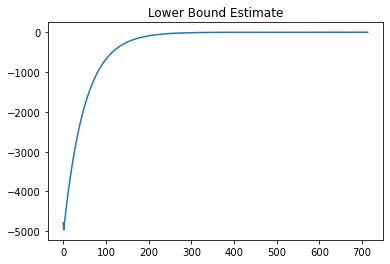

In [49]:
wass_lb_df = pd.DataFrame(np.array(lb[1:]))
plt.figure()
wass_lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

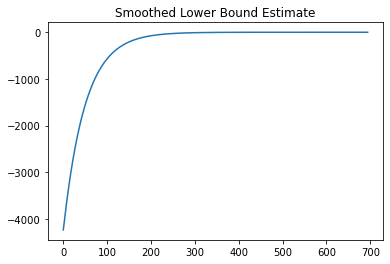

In [50]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

<AxesSubplot:>

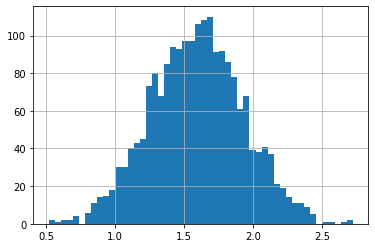

In [51]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 50)

<AxesSubplot:>

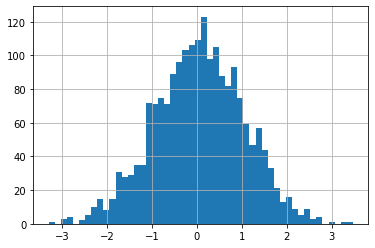

In [52]:
pd.Series(np.random.normal(np.mean(wass_train_summary_statistics[:,0]),np.std(wass_train_summary_statistics[:,0]), len(wass_train_summary_statistics[:,0]))
).hist(bins = 50)

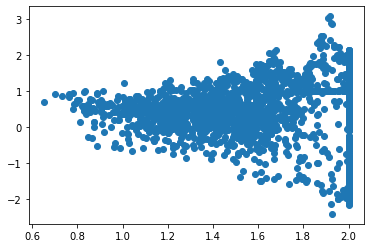

In [53]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,1])

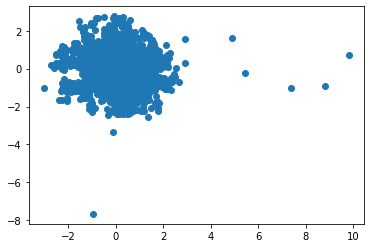

In [54]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,1])

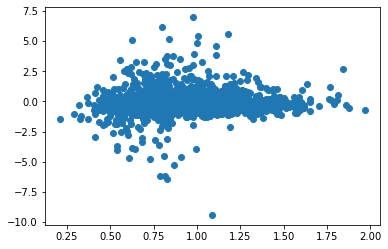

In [59]:
plt.scatter(original_train_summary_statistics[:,2], original_train_summary_statistics[:,3])

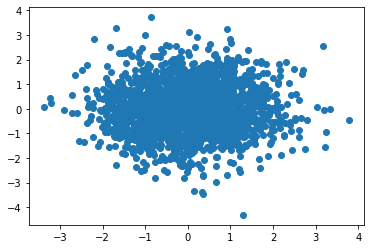

In [60]:
plt.scatter(wass_train_summary_statistics[:,2], wass_train_summary_statistics[:,3])

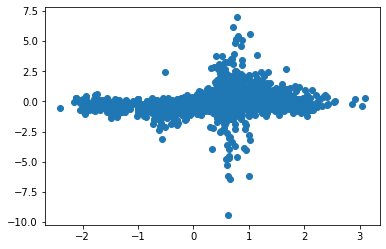

In [62]:
plt.scatter(original_train_summary_statistics[:,1], original_train_summary_statistics[:,3])

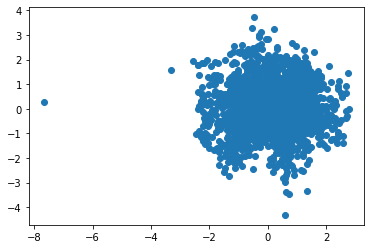

In [63]:
plt.scatter(wass_train_summary_statistics[:,1], wass_train_summary_statistics[:,3])

In [57]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-1]

In [66]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

## Testing on dummary data

In [124]:
dataset_dummy = alpha_stable(1.36495524,  0.27388675,  0.78684313, -0.08169088, 30, 4000)
n_summary_statistics_dummy = np.array([alpha_stable_ss(dataset_dummy[i,:]) for i in range(4000)])

In [122]:
transformed = wasserstein_transform(mixture_obj_seq, n_summary_statistics_dummy)

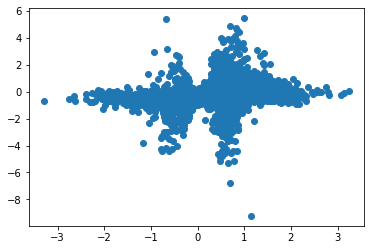

In [125]:
plt.scatter(n_summary_statistics_dummy[:,1], n_summary_statistics_dummy[:,3])

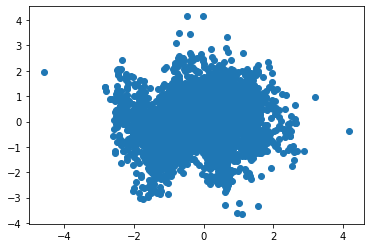

In [140]:
plt.scatter(transformed[:,1], transformed[:,3])

In [126]:
from scipy import stats
z = stats.zscore(transformed)
z_abs = np.abs(z)

In [137]:
z_score_1st = np.where(z_abs[:,1] > 3.5)[0].tolist()
z_score_3rd = np.where(z_abs[:,3] > 3.5)[0].tolist()
z_score_both = z_score_1st + list(set(z_score_3rd) - set(z_score_1st))

In [138]:
transformed_no_outlier_1st = np.delete(transformed[:,1], np.array(z_score_both), axis = 0)
transformed_no_outlier_3rd = np.delete(transformed[:,3], np.array(z_score_both), axis = 0)

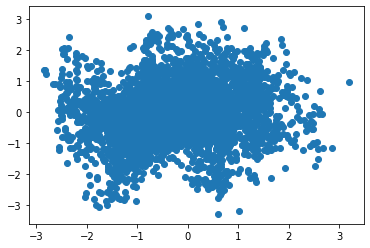

In [139]:
plt.scatter(transformed_no_outlier_1st, transformed_no_outlier_3rd)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [204]:
# Functions must be imported for multiprocessing to work
from functions_robust_wasserstein.f_gradient_lb_wasserstein import (fun_gradient_lb)

In [205]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, gamma_samples = gamma_samples, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, gamma_samples = gamma_samples, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, num_latent = num_latent, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, self.num_coeffs))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [159]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [199]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)

In [209]:
vb = GVB(400, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 100, 100)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
  0%|          | 1/5000 [1:00:26<5035:55:32, 3626.59s/it]

LB -14.470286397174714


  0%|          | 2/5000 [2:08:47<5422:37:17, 3905.85s/it]

LB -14.56569337279708


  0%|          | 3/5000 [3:12:16<5359:49:32, 3861.39s/it]

LB -14.60850343554276


  0%|          | 4/5000 [4:29:08<5770:17:41, 4157.94s/it]

LB -14.436348362983285


  0%|          | 5/5000 [5:44:11<5941:28:46, 4282.15s/it]

LB -13.987738973042864


  0%|          | 6/5000 [6:49:21<5764:47:13, 4155.63s/it]

LB -13.914306829961836


  0%|          | 7/5000 [7:49:59<5529:05:14, 3986.52s/it]

LB -13.834408358146133


  0%|          | 8/5000 [8:50:33<5372:11:50, 3874.18s/it]

LB -13.712672742470765


  0%|          | 9/5000 [9:52:07<5292:59:22, 3817.82s/it]

LB -13.55271767319064


  0%|          | 10/5000 [11:02:40<5469:43:15, 3946.09s/it]

LB -13.674516733840951


  0%|          | 11/5000 [12:24:58<5889:23:53, 4249.72s/it]

LB -13.50737074917322


  0%|          | 12/5000 [13:36:39<5909:55:22, 4265.38s/it]

LB -13.172859482066997


  0%|          | 13/5000 [14:48:33<5928:48:09, 4279.87s/it]

LB -13.421071327424562


  0%|          | 14/5000 [16:00:12<5935:50:20, 4285.80s/it]

LB -12.974555663569008


  0%|          | 15/5000 [17:11:30<5931:28:10, 4283.51s/it]

LB -13.083703445803517


  0%|          | 16/5000 [18:23:31<5945:57:13, 4294.83s/it]

LB -12.912616140381168


  0%|          | 17/5000 [19:16:23<5477:05:32, 3956.96s/it]

LB -12.795377854255022


  0%|          | 18/5000 [20:38:31<5880:04:28, 4248.95s/it]

LB -12.788472398882767


  0%|          | 19/5000 [21:50:17<5902:27:37, 4265.98s/it]

LB -12.646091050502145


  0%|          | 20/5000 [23:13:42<6208:05:57, 4487.78s/it]

LB -12.714748063906313


  0%|          | 21/5000 [24:20:30<6007:56:30, 4343.96s/it]

LB -12.467699247427424


  0%|          | 22/5000 [25:27:22<5868:48:58, 4244.22s/it]

LB -12.503728920463741


  0%|          | 23/5000 [27:11:46<6705:24:51, 4850.21s/it]

LB -12.50888509322632


  0%|          | 24/5000 [28:22:12<6445:31:15, 4663.16s/it]

LB -12.33046057909308


  0%|          | 25/5000 [29:25:14<6078:44:52, 4398.69s/it]

LB -12.292195245208427


  1%|          | 26/5000 [30:28:48<5834:59:57, 4223.16s/it]

LB -12.365421746211375


  1%|          | 27/5000 [31:32:34<5669:17:50, 4104.06s/it]

LB -12.36198215381023


  1%|          | 28/5000 [33:07:32<6328:38:11, 4582.28s/it]

LB -12.244089022203761


  1%|          | 29/5000 [34:39:28<6714:18:40, 4862.51s/it]

LB -12.342144315181358


  1%|          | 30/5000 [35:58:45<6669:14:59, 4830.84s/it]

LB -12.20524675387994


  1%|          | 31/5000 [37:12:23<6496:57:00, 4706.99s/it]

LB -12.33267057697145


  1%|          | 32/5000 [38:25:27<6361:39:03, 4609.89s/it]

LB -12.273517518315941


  1%|          | 33/5000 [39:38:15<6260:25:08, 4537.45s/it]

LB -12.239034779971462


  1%|          | 34/5000 [40:47:24<6098:15:15, 4420.80s/it]

LB -12.102073826173505


  1%|          | 35/5000 [41:52:08<5874:54:53, 4259.76s/it]

LB -12.150348413581082


  1%|          | 36/5000 [42:57:45<5740:20:14, 4163.02s/it]

LB -12.096716772213798


  1%|          | 37/5000 [47:10:47<10296:19:34, 7468.62s/it]

LB -12.259687777889424


  1%|          | 38/5000 [47:57:44<8370:47:39, 6073.13s/it] 

LB -12.102992833226844


  1%|          | 39/5000 [48:58:27<7364:41:01, 5344.26s/it]

LB -12.107008794001192


  1%|          | 40/5000 [66:41:08<31508:49:05, 22869.30s/it]

LB -12.020958400691725


  1%|          | 41/5000 [68:36:11<24904:07:45, 18079.22s/it]

LB -12.017133879231592


  1%|          | 42/5000 [70:02:59<19581:23:38, 14218.04s/it]

LB -12.123496344900845


  1%|          | 43/5000 [71:18:56<15586:35:04, 11319.69s/it]

LB -12.14688251099136


  1%|          | 44/5000 [72:37:30<12855:13:15, 9337.93s/it] 

LB -11.919536881902333


  1%|          | 45/5000 [73:49:23<10777:40:42, 7830.40s/it]

LB -11.927341665044572


  1%|          | 46/5000 [75:02:12<9346:45:20, 6792.15s/it] 

LB -12.077846748401146


  1%|          | 47/5000 [76:14:40<8335:57:47, 6058.85s/it]

LB -11.990588061735064


  1%|          | 48/5000 [77:27:08<7628:05:31, 5545.46s/it]

LB -11.975084099835033


  1%|          | 49/5000 [78:39:37<7132:53:16, 5186.51s/it]

LB -12.143953160654277


  1%|          | 50/5000 [79:53:44<6826:34:38, 4964.78s/it]

LB -11.92422817763555


  1%|          | 51/5000 [81:27:36<7100:30:22, 5165.05s/it]

LB -11.906188744391288


  1%|          | 52/5000 [82:34:06<6614:16:22, 4812.32s/it]

LB -11.976015815266804


  1%|          | 53/5000 [83:35:49<6155:53:47, 4479.73s/it]

LB -11.912829178315924


  1%|          | 54/5000 [84:36:37<5811:45:21, 4230.15s/it]

LB -11.888885820995888


  1%|          | 55/5000 [85:36:37<5550:37:16, 4040.90s/it]

LB -12.02645804093546


  1%|          | 56/5000 [86:37:37<5392:33:05, 3926.62s/it]

LB -11.851700574596872


  1%|          | 57/5000 [87:37:23<5251:26:58, 3824.64s/it]

LB -11.769776497126543


  1%|          | 58/5000 [88:37:28<5160:00:49, 3758.81s/it]

LB -11.752118752574011


  1%|          | 59/5000 [89:49:26<5388:56:13, 3926.37s/it]

LB -12.01299686109474


  1%|          | 60/5000 [90:47:24<5203:32:51, 3792.06s/it]

LB -11.864214348100463


  1%|          | 61/5000 [91:51:56<5235:01:23, 3815.77s/it]

LB -11.918882483026177


  1%|          | 62/5000 [92:49:56<5096:10:11, 3715.31s/it]

LB -11.823643459027204


  1%|▏         | 63/5000 [93:48:39<5015:56:20, 3657.56s/it]

LB -11.934327699939159


  1%|▏         | 64/5000 [95:06:01<5419:47:11, 3952.84s/it]

LB -11.853854457526554


  1%|▏         | 65/5000 [96:05:25<5258:43:40, 3836.15s/it]

LB -11.829827507815242


  1%|▏         | 66/5000 [97:03:58<5124:48:52, 3739.22s/it]

LB -11.964067202365817


  1%|▏         | 67/5000 [98:27:12<5639:25:10, 4115.53s/it]

LB -11.75841461063343


  1%|▏         | 68/5000 [99:25:51<5393:18:51, 3936.73s/it]

LB -11.940309263039053


  1%|▏         | 69/5000 [100:24:02<5208:59:47, 3802.96s/it]

LB -11.940248420988194


  1%|▏         | 70/5000 [101:23:03<5100:10:19, 3724.26s/it]

LB -11.774375039190788


  1%|▏         | 71/5000 [102:21:07<5000:30:27, 3652.23s/it]

LB -11.89891534888617


  1%|▏         | 72/5000 [103:03:38<4547:19:33, 3321.91s/it]

LB -11.862341972060365


  1%|▏         | 73/5000 [103:42:50<4148:09:04, 3030.92s/it]

LB -11.733963819725341


  1%|▏         | 74/5000 [104:21:54<3865:21:29, 2824.87s/it]

LB -11.725543881328512


  2%|▏         | 75/5000 [105:01:03<3669:10:18, 2682.03s/it]

LB -11.603435800246904


  2%|▏         | 76/5000 [105:39:57<3525:51:51, 2577.80s/it]

LB -11.604041505736143


  2%|▏         | 77/5000 [106:24:38<3567:17:13, 2608.62s/it]

LB -11.801539790049246


  2%|▏         | 78/5000 [107:03:54<3462:56:06, 2532.83s/it]

LB -11.646032451559046


  2%|▏         | 79/5000 [107:42:57<3384:31:47, 2475.98s/it]

LB -11.660097664929832


  2%|▏         | 80/5000 [108:22:23<3338:30:25, 2442.81s/it]

LB -11.639376858438718


  2%|▏         | 81/5000 [109:01:17<3293:20:59, 2410.26s/it]

LB -11.680952551455682


  2%|▏         | 82/5000 [109:40:22<3265:54:06, 2390.66s/it]

LB -11.592903355158548


  2%|▏         | 83/5000 [110:19:23<3244:47:23, 2375.69s/it]

LB -11.710147974067509


  2%|▏         | 84/5000 [110:58:50<3240:44:08, 2373.20s/it]

LB -11.68709798493522


  2%|▏         | 85/5000 [111:38:11<3235:04:06, 2369.53s/it]

LB -11.661413956874062


  2%|▏         | 86/5000 [112:17:15<3223:51:27, 2361.80s/it]

LB -11.641148907316072


  2%|▏         | 87/5000 [112:56:30<3220:23:21, 2359.74s/it]

LB -11.610336310430005


  2%|▏         | 88/5000 [113:35:35<3213:55:38, 2355.48s/it]

LB -11.646387138426235


  2%|▏         | 89/5000 [114:15:09<3220:39:08, 2360.89s/it]

LB -11.673709919924033


  2%|▏         | 90/5000 [114:54:04<3209:28:18, 2353.18s/it]

LB -11.618677203081972


  2%|▏         | 91/5000 [115:33:10<3205:59:45, 2351.11s/it]

LB -11.839727760646133


  2%|▏         | 92/5000 [116:12:26<3207:22:02, 2352.59s/it]

LB -11.64013061053286


  2%|▏         | 93/5000 [116:51:33<3204:19:12, 2350.84s/it]

LB -11.571601518978836


  2%|▏         | 94/5000 [117:31:09<3213:55:37, 2358.36s/it]

LB -11.610902899088392


  2%|▏         | 95/5000 [118:10:07<3205:05:38, 2352.36s/it]

LB -11.547866761880854


  2%|▏         | 96/5000 [118:48:58<3195:36:47, 2345.88s/it]

LB -11.610949131550626


  2%|▏         | 97/5000 [119:28:08<3196:44:06, 2347.18s/it]

LB -11.59745260061746


  2%|▏         | 98/5000 [120:08:23<3223:53:55, 2367.61s/it]

LB -11.652765313681316


  2%|▏         | 99/5000 [120:47:20<3210:38:34, 2358.36s/it]

LB -11.546041991447316


  2%|▏         | 100/5000 [121:26:52<3215:24:37, 2362.34s/it]

LB -11.615017354212116


  2%|▏         | 101/5000 [122:05:57<3207:47:45, 2357.23s/it]

LB Smoothed -12.217034162345756


  2%|▏         | 102/5000 [122:45:04<3202:55:03, 2354.12s/it]

LB Smoothed -12.186782816838212


  2%|▏         | 103/5000 [123:24:40<3211:17:28, 2360.76s/it]

LB Smoothed -12.156645616347893


  2%|▏         | 104/5000 [124:03:42<3202:52:53, 2355.06s/it]

LB Smoothed -12.128401850488281


  2%|▏         | 105/5000 [124:42:44<3196:53:10, 2351.13s/it]

LB Smoothed -12.103889618574796


  2%|▏         | 106/5000 [125:21:52<3194:59:43, 2350.22s/it]

LB Smoothed -12.079750080430774


  2%|▏         | 107/5000 [126:01:26<3204:00:37, 2357.33s/it]

LB Smoothed -12.056413049576854


  2%|▏         | 108/5000 [126:40:42<3202:40:42, 2356.84s/it]

LB Smoothed -12.034452389951992


  2%|▏         | 109/5000 [127:19:46<3196:56:03, 2353.09s/it]

LB Smoothed -12.014437953861794


  2%|▏         | 110/5000 [127:58:43<3189:35:48, 2348.17s/it]

LB Smoothed -11.991999195458419


  2%|▏         | 111/5000 [128:37:39<3183:54:24, 2344.46s/it]

LB Smoothed -11.972376714078461


  2%|▏         | 112/5000 [129:27:05<3436:32:40, 2531.01s/it]

LB Smoothed -11.955633175542248


  2%|▏         | 113/5000 [130:09:42<3446:31:00, 2538.87s/it]

LB Smoothed -11.9361455721638


  2%|▏         | 114/5000 [130:48:57<3370:59:09, 2483.74s/it]

LB Smoothed -11.92190510740294


  2%|▏         | 115/5000 [131:28:25<3323:11:50, 2449.03s/it]

LB Smoothed -11.90447607716959


  2%|▏         | 116/5000 [132:07:40<3284:01:16, 2420.65s/it]

LB Smoothed -11.889107396413152


  2%|▏         | 117/5000 [132:46:54<3256:25:50, 2400.81s/it]

LB Smoothed -11.875306868504587


  2%|▏         | 118/5000 [133:26:03<3234:47:19, 2385.34s/it]

LB Smoothed -11.862706911758451


  2%|▏         | 119/5000 [134:11:12<3365:43:40, 2482.41s/it]

LB Smoothed -11.85091117051029


  2%|▏         | 120/5000 [134:50:14<3307:54:29, 2440.26s/it]

LB Smoothed -11.839324304561872


  2%|▏         | 121/5000 [135:29:17<3267:30:13, 2410.95s/it]

LB Smoothed -11.829328253020515


  2%|▏         | 122/5000 [136:08:52<3252:30:00, 2400.37s/it]

LB Smoothed -11.818133978102354


  2%|▏         | 123/5000 [136:48:10<3234:25:52, 2387.52s/it]

LB Smoothed -11.806785330610095


  2%|▏         | 124/5000 [137:27:16<3217:02:24, 2375.17s/it]

LB Smoothed -11.79647698192752


  2%|▎         | 125/5000 [138:06:18<3202:41:40, 2365.07s/it]

LB Smoothed -11.787261810251149


  3%|▎         | 126/5000 [139:01:21<3582:54:28, 2646.38s/it]

LB Smoothed -11.779072463015828


  3%|▎         | 127/5000 [141:08:14<5599:22:14, 4136.62s/it]

LB Smoothed -11.769214564386779


  3%|▎         | 128/5000 [143:17:53<7076:50:40, 5229.20s/it]

LB Smoothed -11.761556938699373


  3%|▎         | 129/5000 [145:24:54<8046:20:41, 5946.80s/it]

LB Smoothed -11.750778557986777


  3%|▎         | 130/5000 [147:01:22<7979:59:51, 5898.97s/it]

LB Smoothed -11.741594514264472


  3%|▎         | 131/5000 [148:34:41<7856:52:21, 5809.15s/it]

LB Smoothed -11.729570509172742


  3%|▎         | 132/5000 [150:02:37<7639:05:40, 5649.29s/it]

LB Smoothed -11.720452671165349


  3%|▎         | 133/5000 [151:34:38<7585:21:33, 5610.70s/it]

LB Smoothed -11.711965850258782


  3%|▎         | 134/5000 [153:19:59<7871:37:19, 5823.64s/it]

LB Smoothed -11.703892434113964


  3%|▎         | 135/5000 [155:41:29<8951:15:42, 6623.75s/it]

LB Smoothed -11.695127518247622


  3%|▎         | 136/5000 [157:45:42<9285:17:20, 6872.34s/it]

LB Smoothed -11.686559629078241


  3%|▎         | 137/5000 [159:49:30<9508:42:50, 7039.15s/it]

LB Smoothed -11.675475922102914


  3%|▎         | 138/5000 [161:53:01<9657:21:45, 7150.66s/it]

LB Smoothed -11.6666263418288


  3%|▎         | 139/5000 [165:16:56<11715:12:43, 8676.15s/it]

LB Smoothed -11.658664191588548


  3%|▎         | 140/5000 [167:13:01<11019:26:57, 8162.56s/it]

LB Smoothed -11.65020934527338


  3%|▎         | 141/5000 [169:45:59<11428:37:14, 8467.39s/it]

LB Smoothed -11.641766772414625


  3%|▎         | 142/5000 [175:32:34<16416:57:44, 12165.72s/it]

LB Smoothed -11.632278638578628


  3%|▎         | 143/5000 [177:50:54<14848:55:32, 11006.00s/it]

LB Smoothed -11.623229683974747


In [ ]:
LB_estimate

In [ ]:
best_lambda

## PLOT DENSITY PLOT OF ALL COEFFS


In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
np.savetxt('vb_lb_varobust_wasserstein.txt', LB_estimate)

In [ ]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

## RUN MCMC WITH ADAPTIVE RANDOM WALK

In [ ]:
num_samples = 50000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

	# ------------------- initialize MCMC

	w_size = num_coeffs  # num of weights and bias

	pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
	pos_w_tilde = np.ones((samples, w_size))

	w_tilde = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
	# w_tilde = [np.log((actual_summary_statistics[0]-1.1)/(2-actual_summary_statistics[0])), np.log((1+actual_summary_statistics[1])/(1-actual_summary_statistics[1])), np.log(actual_summary_statistics[2]), actual_summary_statistics[3]]

	alpha = (2 * np.exp(w_tilde[0]) + 1.1) / (1 + np.exp(w_tilde[0]))
	beta = (np.exp(w_tilde[1]) - 1) / (np.exp(w_tilde[1]) + 1)
	gamma = np.exp(w_tilde[2])
	delta = w_tilde[3]
	w = np.array([alpha, beta, gamma, delta])

	# GENERATE GAMMA
	Gamma_init = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
	adjusted_w = np.concatenate((np.tile(w, (gamma_samples, 1)), Gamma_init), axis = 1)
	# --------------------- 

	prior_current = prior(w_tilde)  # takes care of the gradients

	likelihood_current = variance_adjustment_unbiased_log_likelihood(adjusted_w)

	naccept = 0
		
	for i in range(samples - 1):
		if i < 2000:
			w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
		else:
			if i % 500 == 0:
				Sign = np.cov(pos_w_tilde[0:i, :].T)
			u_proposal = random.uniform(0, 1)
			if u_proposal < 0.05:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = ((0.1**2/w_size) * np.identity(w_size)))
			else:
				w_proposal_tilde = multivariate_normal.rvs(mean = w_tilde, cov = (2.38**2/w_size) * Sign)

		alpha_prop = (2 * np.exp(w_proposal_tilde[0]) + 1.1) / (1 + np.exp(w_proposal_tilde[0]))
		beta_prop = (np.exp(w_proposal_tilde[1]) - 1) / (np.exp(w_proposal_tilde[1]) + 1)
		gamma_prop = np.exp(w_proposal_tilde[2])
		delta_prop = w_proposal_tilde[3]
		w_proposal = np.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

		# GENERATE GAMMA
		Gamma = np.random.exponential(scale = 0.5, size = (gamma_samples, num_latent))
		adjusted_w_proposal = np.concatenate((np.tile(w_proposal, (gamma_samples, 1)), Gamma), axis = 1)
		# --------------------- 

		prior_proposal = prior(w_proposal_tilde)  # takes care of the gradients
		likelihood_proposal = variance_adjustment_unbiased_log_likelihood(adjusted_w_proposal)

		diff_prior = prior_proposal - prior_current

		diff_likelihood = likelihood_proposal - likelihood_current

		try:
			mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

		except OverflowError as e:
			mh_prob = 1


		u = random.uniform(0, 1)

		if u < mh_prob:
			# Update position 
			naccept += 1
			likelihood_current = likelihood_proposal
			prior_current = prior_proposal
			w_tilde = w_proposal_tilde
			w = w_proposal
			pos_w_tilde[i + 1,] = w_proposal_tilde	
			pos_w[i + 1,] = w_proposal
			print(i, pos_w[i + 1,])

		else:
			pos_w_tilde[i + 1,] = pos_w_tilde[i,]
			pos_w[i + 1,] = pos_w[i,]

	print(naccept, ' num accepted')
	print(naccept / (samples * 1.0) * 100, '% was accepted')
	accept_ratio = naccept / (samples * 1.0) * 100

	return (pos_w, pos_w_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

In [ ]:
pos_w = np.loadtxt('mcmc_w_varobust.txt')
pos_w_tilde = np.loadtxt('mcmc_w_tilde_varobust.txt')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
x_plot = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.075, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.155, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


In [ ]:
plt.figure()

pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
x_plot = np.arange((pos_beta_mean-4*pos_beta_std), (pos_beta_mean+4*pos_beta_std), 0.001)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


In [ ]:
plt.figure()

pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
x_plot = np.arange((pos_gamma_mean-4*pos_gamma_std), (pos_gamma_mean+4*pos_gamma_std), 0.002)
kde = KernelDensity(bandwidth=0.02, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0375, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.025, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


In [ ]:
plt.figure()

pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
x_plot = np.arange((pos_delta_mean-4*pos_delta_std), (pos_delta_mean+4*pos_delta_std), 0.002)
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')


In [ ]:
alpha_trace = pos_w[int(num_burnin):,0]
beta_trace = pos_w[int(num_burnin):,1]
gamma_trace = pos_w[int(num_burnin):,2]
delta_trace = pos_w[int(num_burnin):,3]

x = np.arange(len(alpha_trace))
plt.figure(facecolor = 'white')
plt.plot(x, alpha_trace, label='Alpha')  
plt.plot(x, beta_trace, label='Beta')  
plt.plot(x, gamma_trace, label='Gamma')  
plt.plot(x, delta_trace, label='Delta')  
plt.xlabel('Number of samples')
plt.ylabel('Theta')
plt.legend()
plt.title("Trace Plot for Theta")
plt.show()